In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### Loading Dataset
Dataset source: https://www.kaggle.com/datasets/skillsmuggler/amazon-ratings

In [2]:
dataset = pd.read_csv("dataset/user-product-rating.csv")

#### Dataset Description
The dataset contains 2 million beauty related products reviews from Amazon.com, a popular electronic commerce website.

- UserId: Customer Identification
- ProductId: Product ASIN (Amazon's unique product identification code for each product)
- Ratings: rating ranging from 1-5 based on customer satisfaction
- Timestamp: time when the rating is submitted (in UNIX time)

In [3]:
dataset.head()

,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200


In [4]:
for col in dataset.columns:
    null_value = dataset[col].isnull().sum()
    if null_value > 0:
        print(f"{null_value} missing value(s) in {col} column.")
    else:
        print(f"No missing value in {col} column.")

No missing value in UserId column.
No missing value in ProductId column.
No missing value in Rating column.
No missing value in Timestamp column.


In [5]:
print(f"The dataset contains {dataset.shape[0]} rows of data.")

The dataset contains 2023070 rows of data.


In [6]:
# User
print(f"... User Statistics ...")
print(f"Unique users: {dataset['UserId'].nunique()}")
print(f"User maximum frequency: {dataset['UserId'].value_counts().max()}")
print(f"User minimum frequency: {dataset['UserId'].value_counts().min()}")


... User Statistics ...
Unique users: 1210271
User maximum frequency: 389
User minimum frequency: 1


In [7]:
# Product
print(f"... Product Statistics ...")
print(f"Unique prducts: {dataset['ProductId'].nunique()}")
print(f"Product maximum frequency: {dataset['ProductId'].value_counts().max()}")
print(f"Product minimum frequency: {dataset['ProductId'].value_counts().min()}")


... Product Statistics ...
Unique prducts: 249274
Product maximum frequency: 7533
Product minimum frequency: 1


In [8]:
dataset = dataset.drop(columns='Timestamp')

# Convert UserId and ProductId from str to int
dataset['UserId'] = dataset['UserId'].astype('category').cat.codes
dataset['ProductId'] = dataset['ProductId'].astype('category').cat.codes

In [9]:
dataset.head()

,UserId,ProductId,Rating
0,725046,0,5.0
1,814606,1,3.0
2,313101,1,5.0
3,291075,2,4.0
4,802842,3,1.0


### Collaborative Filtering using Embedding (Keras)

**Architecture Overview**\
This architecture is a simple one which does not involve dense layer and activation function for more complex feature extractions. It only works as a matrix factorisation model implemented with neural network layers (embeddings).

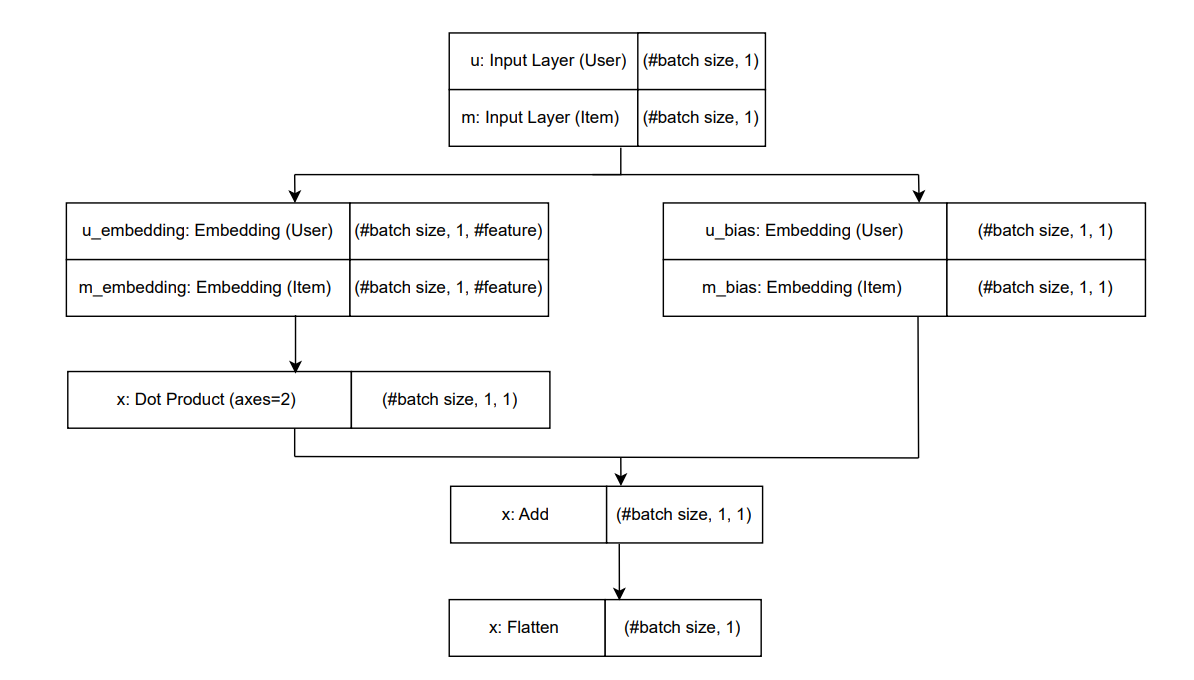

1. **Input layers**\
The respective input layers takes in user ID and product ID.

    > Input shape: (#batch size, 1)\
    > Output shape: (#batch size, 1)
    

2. **Embedding layers**\
Let K be the number of features,each user and product is mapped to a dense vector of size K. These embeddings would represent the latent features of user and product.

    > Input shape: (#batch size, 1)\
    > Output shape: (#batch size, 1, K)


3. **Bias embedding layers**\
The respective bias embedding layers help model to capture the average tendency of user and product.

    > Input shape: (#batch size, 1)\
    > Output shape: (#batch size, 1, 1)


4. **Dot product**\
Computes the dot product between user and product embeddings and this is the predicted rating without bias.

    Based on the matrix factorisation approach in collaborative filtering, let approximate user matrix = $p_u$ and product matrix = $q_i$,
    $$\hat{r}_{ui} = p_u^T q_i$$

    > Input shape: [(#batch size, 1, K), (#batch size, 1, K)]\
    > Output shape: (#batch size, 1, 1)


5. **Add with bias**\
Biases are learnt for a final rating.
    $$\hat{r}_{ui} = \mu + b_u + b_i + p_u^T q_i$$
    Where:
    - $\mu$: Global average rating
    - $b_u$: Bias of user $u$ (how much higher/lower the user tends to rate)
    - $b_i$: Bias of item $i$ (how much more popular the item is)

    > Input shape: [(#batch size, 1, 1), (#batch size, 1, 1)]\
    > Output shape: (#batch size, 1, 1)


6. **Flatten**\
Reshapes the prediction to match the rating format.

    > Input shape: (#batch size, 1, 1)\
    > Output shape: (#batch size, 1)


In [10]:
from sklearn.utils import shuffle
from keras.models import Model
from keras.layers import Input, Embedding, Dot, Add, Flatten
from keras.regularizers import l2
from keras.optimizers import SGD, Adam
from tensorflow.keras import utils

In [11]:
N = dataset['UserId'].nunique() + 1     # number of users
M = dataset['ProductId'].nunique() + 1  # number of items

In [12]:
# split into train and test
df = shuffle(dataset)
cutoff = int(0.8*len(df))
df_train = df.iloc[:cutoff]
df_test = df.iloc[cutoff:]

In [ ]:
# Intitalize variables
K = 10      # latent dimensionality (features)
mu = df_train['Rating'].mean()
epochs = 15
reg = 0.    # regularization penalty

In [ ]:
# Input layers
u = Input(shape=(1,))
m = Input(shape=(1,))

# Embedding layers
u_embedding = Embedding(N, K, embeddings_regularizer=l2(reg))(u)
m_embedding = Embedding(M, K, embeddings_regularizer=l2(reg))(m)

# Bias embedding layers
u_bias = Embedding(N, 1, embeddings_regularizer=l2(reg))(u) 
m_bias = Embedding(M, 1, embeddings_regularizer=l2(reg))(m)  

In [ ]:
# Dot product for embedding layers
x = Dot(axes=2)([u_embedding, m_embedding])  

In [ ]:
# Include bias
x = Add()([x, u_bias, m_bias])

# Flatten to reshape
x = Flatten()(x)

In [19]:
model = Model(inputs=[u, m], outputs=x)
model.compile(
    loss='mse',
    # optimizer='adam',
    # optimizer=Adam(lr=0.01),
    optimizer=SGD(lr=0.08, momentum=0.9),
    metrics=['mse']
)

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# Input must not be format other than int
r = model.fit(
    x=[df_train['UserId'].values, df_train['ProductId'].values],
    y=df_train['Rating'].values - mu,
    epochs=epochs,
    batch_size=128,
    validation_data=(
        [df_test['UserId'].values, df_test['ProductId'].values],
        df_test['Rating'].values - mu
    )
)

Epoch 1/15
6687/6687 [==============================] - 245s 36ms/step - loss: 1.4806 - mse: 1.4806 - val_loss: 1.4490 - val_mse: 1.4490
Epoch 2/15
6687/6687 [==============================] - 271s 40ms/step - loss: 1.3750 - mse: 1.3750 - val_loss: 1.4200 - val_mse: 1.4200
Epoch 3/15
6687/6687 [==============================] - 281s 42ms/step - loss: 1.3032 - mse: 1.3032 - val_loss: 1.4019 - val_mse: 1.4019
Epoch 4/15
6687/6687 [==============================] - 282s 42ms/step - loss: 1.2457 - mse: 1.2457 - val_loss: 1.3897 - val_mse: 1.3897
Epoch 5/15
6687/6687 [==============================] - 280s 42ms/step - loss: 1.1968 - mse: 1.1968 - val_loss: 1.3814 - val_mse: 1.3814
Epoch 6/15
6687/6687 [==============================] - 281s 42ms/step - loss: 1.1541 - mse: 1.1541 - val_loss: 1.3750 - val_mse: 1.3750
Epoch 7/15
6687/6687 [==============================] - 251s 37ms/step - loss: 1.1160 - mse: 1.1160 - val_loss: 1.3704 - val_mse: 1.3704
Epoch 8/15
6687/6687 [===================

In [ ]:
r.history.keys()

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])

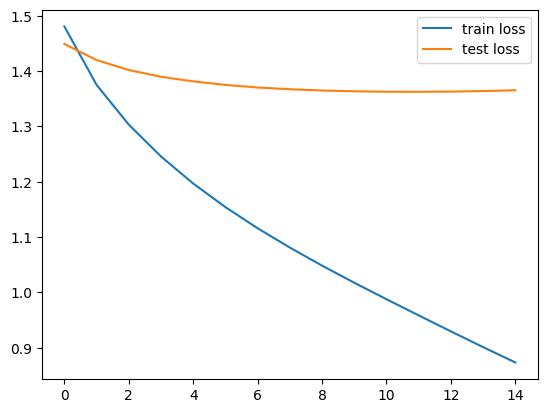

In [ ]:
# plot losses
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend()
plt.show()

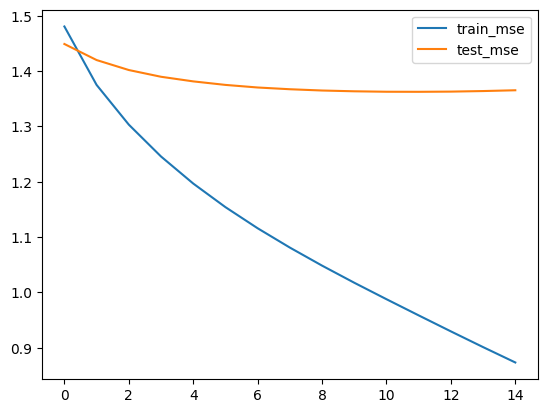

In [ ]:
# plot mse
plt.plot(r.history['mse'], label="train_mse")
plt.plot(r.history['val_mse'], label="test_mse")
plt.legend()
plt.show()

- A significant gap (like 0.9 vs 1.4) suggests overfitting
- On average, the model's predictions are off by around 1 rating point, which is significant for a scale of 0 to 5.

In [ ]:
# Suggestion: Add dropout to prevent overfitting
from tensorflow.keras.layers import SpatialDropout1D

u_embedding = SpatialDropout1D(0.2)(u_embedding)
m_embedding = SpatialDropout1D(0.2)(m_embedding)

# Suggestions:
# Reduce embedding size (K) - limit the complexity
# Check regularization strength - increase l2(reg)

#### Neural Collaborative Filtering (NCF)

**Architecture Overview**

After the embedding layers, dense layers with activation function are added to the architecture to introduce non linear modeling. The model is no longer just dot products of latent vectors but learning complex and non-linear interactions between user and product features.

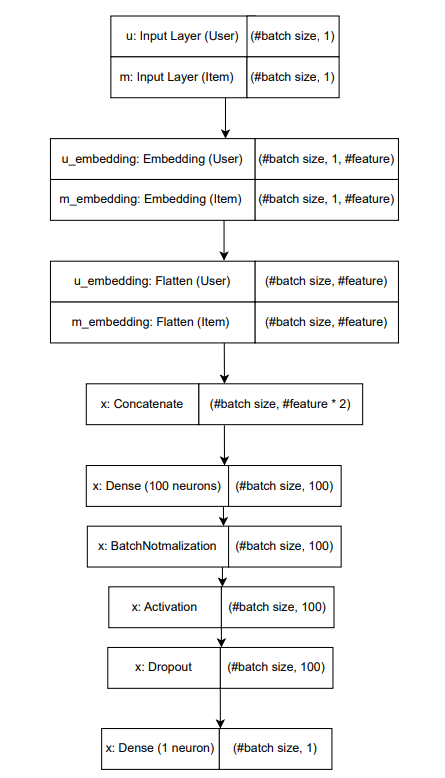

**Input layers**\
The respective input layers takes in user ID and product ID.
> Input shape: (#batch size, 1)\
> Output shape: (#batch size, 1)

**Embedding layers**\
Each user and product is mapped to a K-dimensional vector, where K is the number of latent features.
> Input shape: (#batch size, 1, K)\
> Output shape: (#batch size, 1, K)

**Flatten**\
The 1 dimension is flatten and the layers are reshaped.
> Input shape: (#batch size, K)\
> Output shape: (#batch size, K)

**Concatenate**\
The two embeddings are combined side-by-side.
> Input shape: [(#batch size, K), (#batch size, K)]\
> Output shape: (#batch size, 2K)

**Fully Connected Layers**\
Included dense, batchnormalization, activation and dropout layers. Among these, batchnormalization and dropout layers are optional. Activation function is omitted in linear dense layers since it is to introduce nonlinarity to the dense layer.

**Dense layer**\
Along with activation function, introduces non-linearity and lets the model learn high-order user-item interactions. The output shape is based on the number of nuerons/ hidden representation.

Some tips in choosing number of neurons:
- higher number of neurons: suitable for big size data, may have risk of overfitting on small dataset
- lower number of neurons: fewer parameters so faster generalization, but have risk of underfit (cannot learn rich intearations)
> Input shape: (#batch size, 2K)\
> Output shape: (#batch size, 100)

**Batch Normalization**\
Apply for training stability and improving training speed by normalizing the inputs to the layer.
> Input shape:(#batch size, 100)\
> Output shape: (#batch size, 100)

**Activation Function**\
Introduce nonlinearity to the dense layer.
> Input shape: (#batch size, 100)\
> Output shape: (#batch size, 100)

**Dropout**\
Dropout is applied for regularization and reducing overfitting. Since it will only revert part of the weight to zero, the output shape remains unchanged. Dropout layer is disabled during inferencing so that the full model capacity is utilised for predictions. 
> Input shape: (#batch size, 100)\
> Output shape: (#batch size, 100)

**Dense layer (linear)**\
No activation in this dense layer and it is a regression. It outputs a single predicted rating.
> Input shape: (#batch size, 100)\
> Output shape: (#batch size, 1)

In [ ]:
from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from keras.layers import Dropout, BatchNormalization, Activation
from keras.regularizers import l2
from keras.optimizers import SGD, Adam

In [ ]:
N = dataset['UserId'].nunique() + 1     # number of users
M = dataset['ProductId'].nunique() + 1  # number of items

In [ ]:
# split into train and test
df = shuffle(dataset)
cutoff = int(0.8*len(df))
df_train = df.iloc[:cutoff]
df_test = df.iloc[cutoff:]

In [ ]:
# intitalize variables
K = 10      # latent dimensionality (features)
mu = df_train['Rating'].mean()
epochs = 15
# reg = 0.    # regularization penalty

In [ ]:
# Input layers
u = Input(shape=(1,))
m = Input(shape=(1,))

# Embedding layers
u_embedding = Embedding(N, K)(u) 
m_embedding = Embedding(M, K)(m) 

# Flatten
u_embedding = Flatten()(u_embedding)
m_embedding = Flatten()(m_embedding)

# Concatenate
x = Concatenate()([u_embedding, m_embedding])

In [ ]:
# Build neural network
# Fully connected layers
# x = Dense(200)(x)               # fully connected (dense) layer with 200 neurons (nuerons based on data size, complexity)
x = Dense(100)(x)  
x = BatchNormalization()(x)     # normalize input for next layer, ensure mean=0, var=1 (stabilize & speed up training)
x = Activation('relu')(x)       # introduce non-linearity
x = Dropout(0.2)(x)             # regularization (drop 20% neurons), not needed if no ovefitting
# x = Dense(64)(x)               # introduce more depth, not needed if already perrforming well/starts simple, needed when underfit
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
x = Dense(1)(x)                 # Final layer: give one score + no activation as output is linear (regression)

# Suggestions:
# Start simple with fewer layers and no dropout.
# If the model overfits -> add Dropout.
# If the model struggles to converge -> try BatchNormalization.
# If the model underfits -> add more layers or neurons.

In [ ]:
model = Model(inputs=[u, m], outputs=x)
model.compile(
  loss='mse',
  # optimizer='adam',
  # optimizer=Adam(lr=0.01),
  optimizer=SGD(lr=0.08, momentum=0.9),
  metrics=['mse'],
)

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
r = model.fit(
  x=[df_train['UserId'].values, df_train['ProductId'].values],
  y=df_train['Rating'].values - mu,
  epochs=epochs,
  batch_size=128,
  validation_data=(
    [df_train['UserId'].values, df_train['ProductId'].values],
    df_train['Rating'].values - mu
  )
)

Epoch 1/15
6687/6687 [==============================] - 35s 5ms/step - loss: 1.5380 - mse: 1.5380 - val_loss: 1.5058 - val_mse: 1.5058
Epoch 2/15
6687/6687 [==============================] - 31s 5ms/step - loss: 1.4883 - mse: 1.4883 - val_loss: 1.3820 - val_mse: 1.3820
Epoch 3/15
6687/6687 [==============================] - 30s 5ms/step - loss: 1.3574 - mse: 1.3574 - val_loss: 1.1233 - val_mse: 1.1233
Epoch 4/15
6687/6687 [==============================] - 31s 5ms/step - loss: 1.1042 - mse: 1.1042 - val_loss: 0.8984 - val_mse: 0.8984
Epoch 5/15
6687/6687 [==============================] - 31s 5ms/step - loss: 0.8863 - mse: 0.8863 - val_loss: 0.7301 - val_mse: 0.7301
Epoch 6/15
6687/6687 [==============================] - 33s 5ms/step - loss: 0.7397 - mse: 0.7397 - val_loss: 0.5842 - val_mse: 0.5842
Epoch 7/15
6687/6687 [==============================] - 30s 4ms/step - loss: 0.6146 - mse: 0.6146 - val_loss: 0.4938 - val_mse: 0.4938
Epoch 8/15
6687/6687 [==============================] -

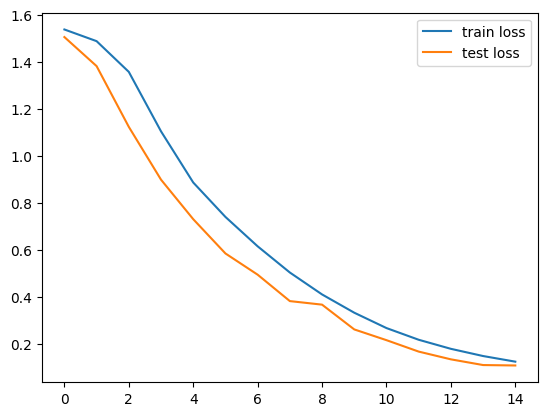

In [ ]:
# plot losses
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend()
plt.show()

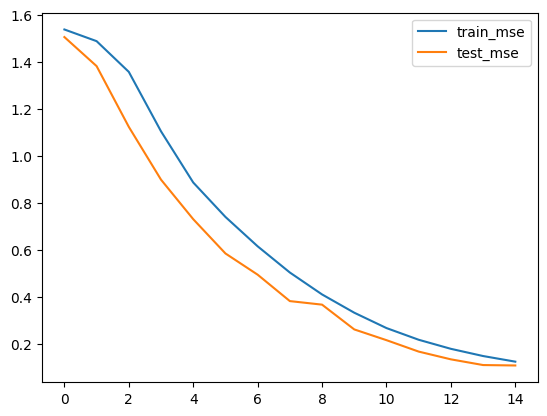

In [ ]:
# plot mse
plt.plot(r.history['mse'], label="train_mse")
plt.plot(r.history['val_mse'], label="test_mse")
plt.legend()
plt.show()

- looks good using deep network
- can experiment using different parameters (eg. number of neurons, add layers, manipulate dropout & regularization)

### Residual Learning

**Architecture Overview**

This model architecture combines both matrix multiplication and neural collaborative filtering, making up a hybrid recommender model. The main branch learn the basic user–item interaction through latent dot products while the side branch capture nonlinear interactions between user and item latent features. In the end, the main prediction and residual correction from the neural network are added together so that the residual error from MF prediction can be compensate by neural network.

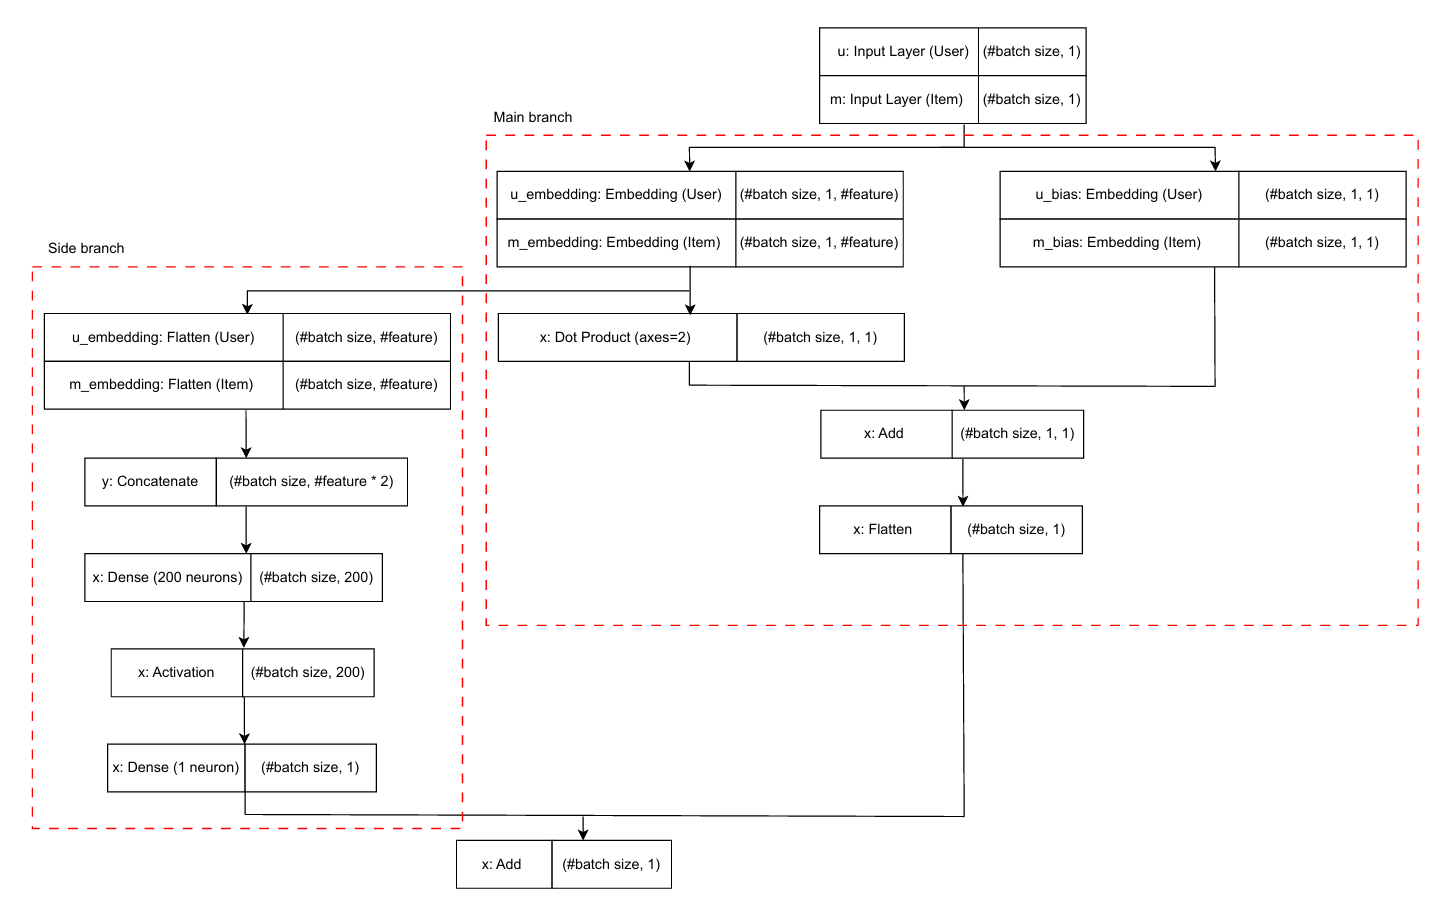

The model can also be customized into weighted hybrid model by assigning different weightage when doing the residual merge.

<pre><code>
Let alpha be the weightage,

final_output = Add()([alpha * dot_product_output, (1 - alpha) * dense_output])
<code><pre>

In [ ]:
# split into train and test
df = shuffle(dataset)
cutoff = int(0.8*len(df))
df_train = df.iloc[:cutoff]
df_test = df.iloc[cutoff:]

In [ ]:
# intitalize variables
K = 10      # latent dimensionality (features)
mu = df_train['Rating'].mean()
epochs = 15
reg = 0.    # regularization penalty

In [ ]:
# keras model
u = Input(shape=(1,))
m = Input(shape=(1,))
u_embedding = Embedding(N, K, embeddings_regularizer=l2(reg))(u)    
m_embedding = Embedding(M, K, embeddings_regularizer=l2(reg))(m)    

In [ ]:
# main branch
u_bias = Embedding(N, 1)(u)
m_bias = Embedding(M, 1)(m)
x = Dot(axes=2)([u_embedding, m_embedding])
x = Add()([x, u_bias, m_bias])
x = Flatten()(x)

In [ ]:
# side branch
u_embedding = Flatten()(u_embedding) 
m_embedding = Flatten()(m_embedding) 
y = Concatenate()([u_embedding, m_embedding])
y = Dense(200)(y)
y = Activation('elu')(y)
# y = Dropout(0.5)(y)
y = Dense(1)(y)

In [ ]:
# merge
x = Add()([x, y])

# # merge based on weightage
# x = Add()([
#     Lambda(lambda x: x * alpha)(x),
#     Lambda(lambda y: y * (1 - alpha))(y)
# ])

In [ ]:
model = Model(inputs=[u, m], outputs=x)
model.compile(
  loss='mse',
  # optimizer='adam',
  # optimizer=Adam(lr=0.01),
  optimizer=SGD(lr=0.08, momentum=0.9),
  metrics=['mse'],
)

In [ ]:
r = model.fit(
  x=[df_train['UserId'].values, df_train['ProductId'].values],
  y=df_train['Rating'].values - mu,
  epochs=epochs,
  batch_size=128,
  validation_data=(
    [df_train['UserId'].values, df_train['ProductId'].values],
    df_train['Rating'].values - mu
  )
)

Epoch 1/15
6687/6687 [==============================] - 277s 41ms/step - loss: 1.4818 - mse: 1.4818 - val_loss: 1.1401 - val_mse: 1.1401
Epoch 2/15
6687/6687 [==============================] - 285s 43ms/step - loss: 1.2417 - mse: 1.2417 - val_loss: 0.9123 - val_mse: 0.9123
Epoch 3/15
6687/6687 [==============================] - 328s 49ms/step - loss: 1.0002 - mse: 1.0002 - val_loss: 0.7622 - val_mse: 0.7622
Epoch 4/15
6687/6687 [==============================] - 294s 44ms/step - loss: 0.8666 - mse: 0.8666 - val_loss: 0.6762 - val_mse: 0.6762
Epoch 5/15
6687/6687 [==============================] - 296s 44ms/step - loss: 0.7821 - mse: 0.7821 - val_loss: 0.6342 - val_mse: 0.6342
Epoch 6/15
6687/6687 [==============================] - 314s 47ms/step - loss: 0.7117 - mse: 0.7117 - val_loss: 0.5522 - val_mse: 0.5522
Epoch 7/15
6687/6687 [==============================] - 291s 43ms/step - loss: 0.6412 - mse: 0.6412 - val_loss: 0.4808 - val_mse: 0.4808
Epoch 8/15
6687/6687 [===================

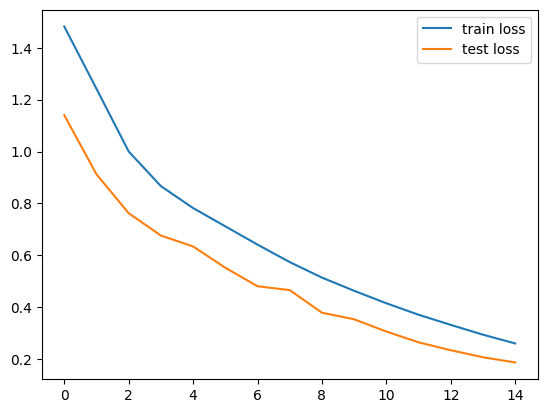

In [ ]:
# plot losses
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend()
plt.show()

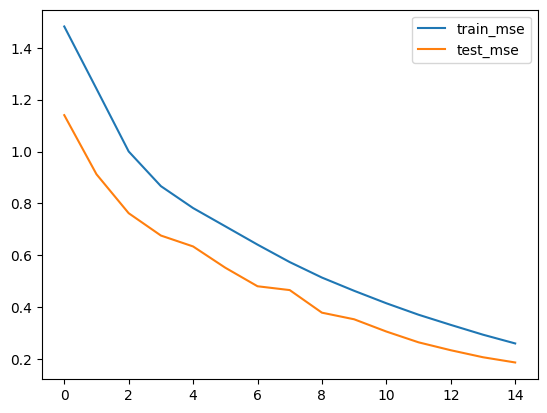

In [ ]:
# plot mse
plt.plot(r.history['mse'], label="train_mse")
plt.plot(r.history['val_mse'], label="test_mse")
plt.legend()
plt.show()